# Notebook 2 : Empirical Luminosity Function

In this notebook, we demonstrate how to generate a simulated population of Milky Way satellites based on the best-fit values presented in the paper and how to apply the selection function. We also show how to obtain the completeness-corrected version of the observed luminosity function.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d


import numpy as np
import random
import math
import matplotlib.pyplot as plt
import xgboost as xgb
import yaml
from os.path import join,exists
import corner
import healpy as hp
import pandas as pd
from scipy.optimize import minimize_scalar
from astropy.coordinates import Galactocentric, ICRS, CartesianRepresentation, spherical_to_cartesian
import astropy.units as u
import astropy.coordinates as coords



In [2]:
config = yaml.safe_load(open('data/read_config.yaml'))

BITS = config['maskbits']
BADBITS = (BITS['EBV'] | BITS['ASSOC'] | BITS['STAR'] | BITS['FOOT'] | BITS['DENSITY'] )

def get_filepath(survey,filetype):
    """Get the filepath for a specific survey and filetype.
    
    Parameters
    ----------
    survey   : survey of interest ['des','ps1']
    filetype : type of data file
    
    Returns
    -------
    filepath : path to file
    """
    filepath = join(config['datadir'],config[survey][filetype])
    return filepath

def detect_prob(ra, dec,d, mv,  rh): 
    
    distance = d/1000 # (pc -> kpc)
    abs_mag = mv
    r_physical = 10**(rh) / 1000 # (log(pc) -> kpc)
    
    delve_pdet = delve_ssf.predict(distance=distance,abs_mag=abs_mag,r_physical=r_physical,ra=ra,dec=dec)
    des_pdet = des_ssf.predict(distance=distance,abs_mag=abs_mag,r_physical=r_physical,ra=ra,dec=dec)
    ps1_pdet = ps1_ssf.predict(distance=distance,abs_mag=abs_mag,r_physical=r_physical,ra=ra,dec=dec)
    
    result = delve_pdet + des_pdet + ps1_pdet
    
  #  bright = mv < -12.5
  #  result[bright] = 1.0

    return result


class SurveySelectionFunction(object):
    """Survey selection function including spatial information."""

    def __init__(self, survey):
        """Initialize survey selection function."""
        self.survey = survey
        print("Loading model...")
        self.model = xgb.XGBClassifier()
        self.model.load_model(get_filepath(self.survey,'model'))
        print("Loading mask...") # This can take a while...
        self.mask = hp.read_map(get_filepath(self.survey,'mask'),dtype=int)
        print("Loading stellar density map...")
        self.density = hp.read_map(get_filepath(self.survey,'density'))

    @staticmethod
    def get_hpxmap_value(hpxmap,lon,lat):
        """Get the value of a healpix map at a given location.
        
        Parameters
        ----------
        hpxmap : HEALPix map (must be in same frame as `lon` and `lat`)
        lon : longitude [deg]
        lat : latitude [deg]
        
        Returns
        -------
        value : healpix map value
        """
        nside = hp.get_nside(hpxmap)
        pix   = hp.ang2pix(nside,lon,lat,lonlat=True)
        return hpxmap[pix]
        
    def get_stellar_density(self, ra, dec):
        """Calculate the stellar density at the location of each satellite.

        Parameters
        ----------
        ra : right ascension [deg]
        dec: declination [deg]
        
        Returns
        -------
        stellar_density : stellar density [stars/arcmin^2]
        """
        return self.get_hpxmap_value(self.density,ra,dec)

    def get_mask_value(self, ra, dec):
        """Calculate the mask value at the location of each satellite.

        Parameters
        ----------
        ra : right ascension [deg]
        dec: declination [deg]
        
        Returns
        -------
        value : mask value
        """
        return self.get_hpxmap_value(self.mask,ra,dec)
    
    def predict(self, distance, abs_mag, r_physical, ra, dec):
        """Predict the satellite detection probability for a survey.
        
        Parameters
        ----------
        distance   : Heliocentric distance [kpc]
        abs_mag    : Absolute V-band magnitude
        r_physical : Physical azimuthally averaged half-light radius [kpc]
        ra         : Right ascension [deg]
        dec        : Declination [deg]

        Returns
        -------
        pdet : detection probability
        """
        # Calculate the stellar density at the location of each satellite.
        stellar_density = self.get_stellar_density(ra,dec)
        
        # Evaluate the model for each satellite
        x_eval = np.vstack([np.log10(distance), abs_mag, np.log10(r_physical), stellar_density]).T
        pred = self.model.predict_proba(x_eval)[:,1]

        #Calculate the mask value at the location of each satellite.
        mask_value = self.get_mask_value(ra,dec)
        # Set pdet to zero for satellites in masked area
        bad = (mask_value & BADBITS) != 0
        pred[bad] = 0
        
        return pred

delve_ssf = SurveySelectionFunction('delvedr3')
des_ssf = SurveySelectionFunction('desy6')
ps1_ssf = SurveySelectionFunction('ps1d')

Loading model...
Loading mask...
Loading stellar density map...
Loading model...
Loading mask...
Loading stellar density map...
Loading model...
Loading mask...


/Users/chinyi/anaconda3/envs/astropy310/lib/python3.10/site-packages/xgboost/sklearn.py:1037: UserWarning: [22:07:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7eg2b3w9sf/croot/xgboost-split_1749630922962/work/src/learner.cc:1069: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  self.get_booster().load_model(fname)


Loading stellar density map...


In [3]:
def radial_3d_function(d, rcore=10000):
    alpha = 0 
    return  (d**(2-alpha))*((d+(rcore))**(alpha-3))

def size_function(rh, mv, sigma, zp, sp):
    mean = zp + sp * (mv + 6)
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((rh - mean) / sigma) ** 2)


# Rejection sampling function
def sample_radial_function(n_samples, rcore=1.0, d_min = 0, d_max = 300*1000): 
    a = rcore
    result = minimize_scalar(lambda d: -radial_3d_function(d), bounds=(d_min + 1e-5, d_max), method='bounded')
    pdf_max = -result.fun
    
    samples = []
    while len(samples) < n_samples:
        d_trial = np.random.uniform(d_min, d_max)
        u = np.random.uniform(0, pdf_max)
        if u < radial_3d_function(d_trial, a):
            samples.append(d_trial)
    return np.array(samples)

def sample_luminosity_function(n, beta, xmin=-20, xmax=0):
    u = np.random.rand(n)
    return (1/beta) * np.log10(u * (10**(beta * xmax) - 10**(beta * xmin)) + 10**(beta * xmin))


def sample_radial_function(rcore, d_min, d_max,n_samples):
    a = rcore
    result = minimize_scalar(lambda d: -radial_3d_function(d), bounds=(d_min + 1e-5, d_max), method='bounded')
    pdf_max = -result.fun
    samples = []
    while len(samples) < n_samples:
        d_trial = np.random.uniform(d_min, d_max)
        u = np.random.uniform(0, pdf_max)
        if u < radial_3d_function(d_trial, a):
            samples.append(d_trial)
    return np.array(samples)

def sample_size_function(mv_samples, sigma, zp, sp):
    # Gaussian sampling, conditional on mv
    means = zp + sp * (mv_samples + 6)
    return np.random.normal(loc=means, scale=sigma)

# Wrapper to sample all
def sample_joint_distribution(beta1, alpha, sigma, zp, sp,
                              mv_min=-20., mv_max=0, d_min=10000, d_max=300000, size=1000):
    mv = sample_luminosity_function(size,beta1)
    d = sample_radial_function(alpha, d_min, d_max, size)
    rh = sample_size_function(mv, sigma, zp, sp)
    return mv, d, rh

Here we present the posterior distributions of the parameters in our empirical models. See the paper for details on each parameter.

In [4]:
kwargs_corner = {'bins': 20, 'smooth': 0.7, 'smooth1d': None, 'plot_datapoints': False,
             'label_kwargs': dict(fontsize=13), 'levels': [0.68,0.95],
             'fill_contours': True, 'alpha': 0.2, 
            }


title_list = [r'$\beta$' ,r'$r_{\rm core}$', r'$\sigma$','$z_p$','$s_p$','N']

full_title_list = [r'LF slope, $\beta$',r'Core radius, $r_{\rm core}$',
                               r'Size scatter, $\sigma$','Size offset, $z_p$','Size slope, $s_p$','Number of galaxies, N']
    

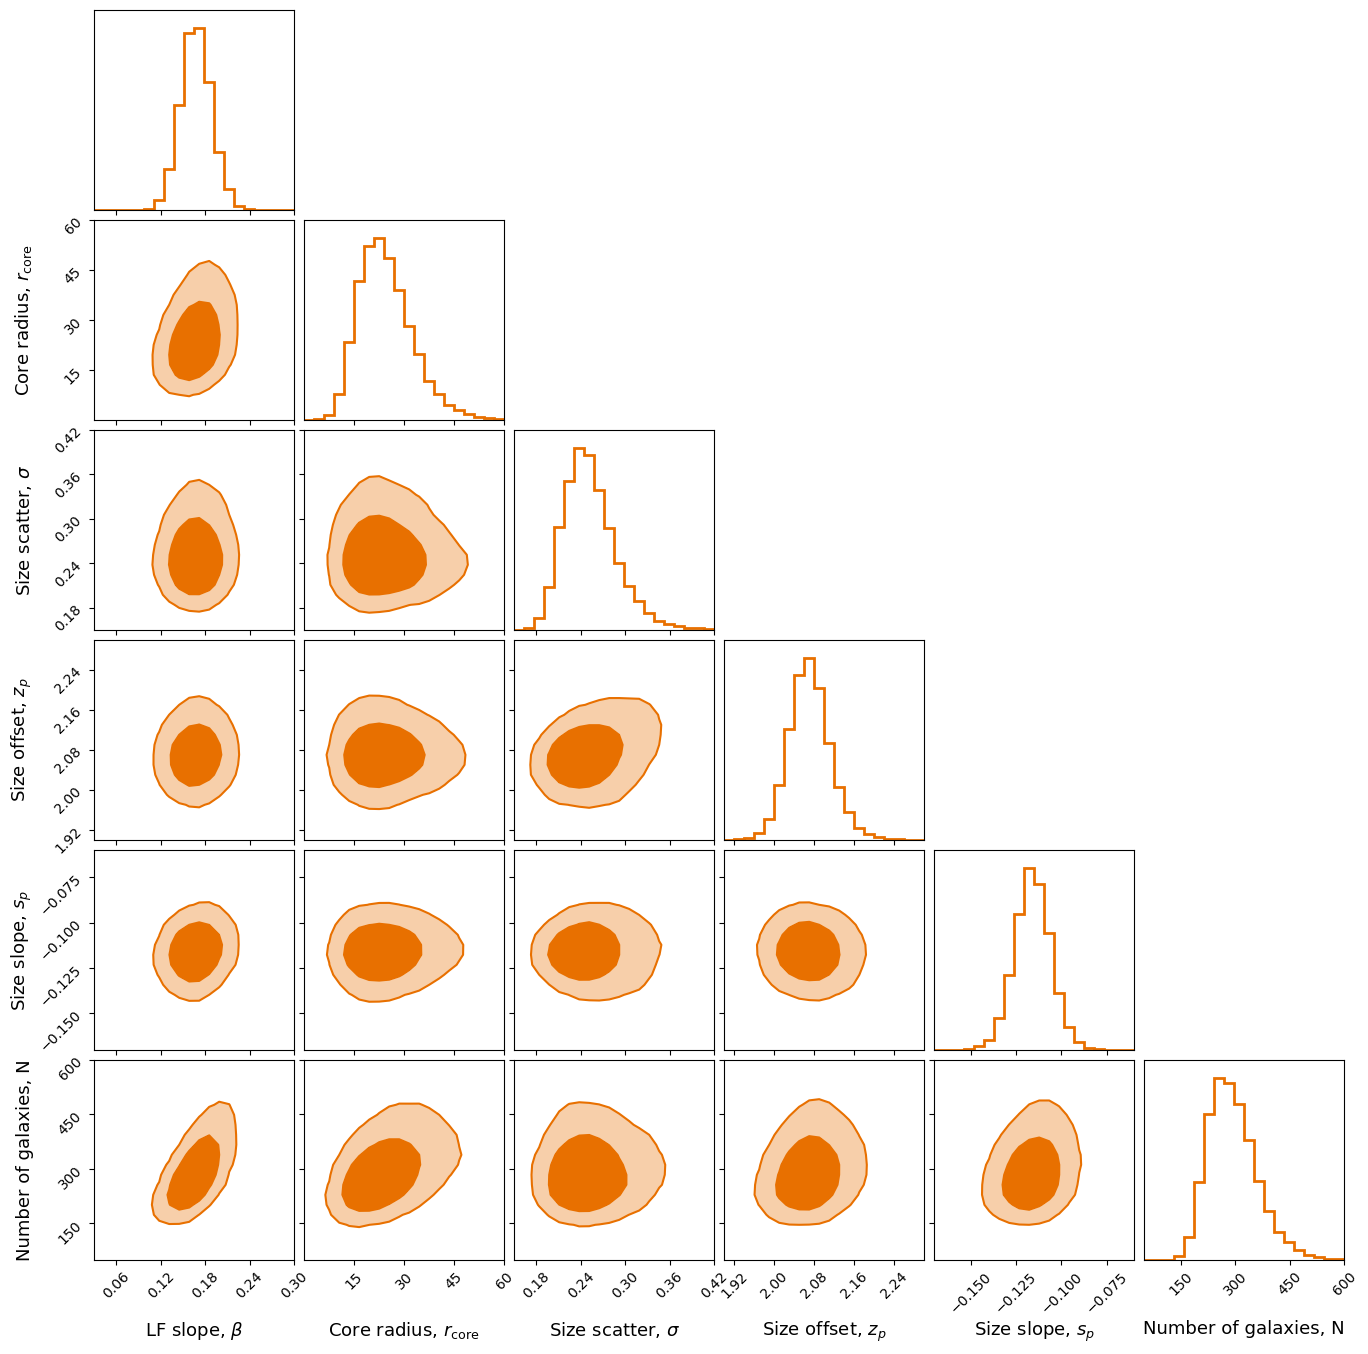

In [5]:
samples3 =  np.load('data/mcmc_chain_delve_v4.npy',)

fig = corner.corner(samples3, color='#e87000',  
                    labels=full_title_list, title_fmt = '.2f',
                    show_titles=False,title_kwargs={"fontsize": 14}, 
                    range=[[0.03,0.3],[0,60],[0.15,0.42],[1.9,2.3],[-0.17,-0.06],[50,600]],
                     hist_kwargs= {'linewidth': 2,},**kwargs_corner)

plt.show()
plt.close()

Here we start generating mock poppulation based on the best fit values

In [6]:


#samples3 = samples3[samples3[:,0]>-1.25]

mv_comb = []
d_comb = []
rh_comb = []
DL_comb = []
mask_comb= []



num_runs =  500 

for i in range(num_runs): #200
    sample_num = random.randint(0, len(samples3 ))
    beta1 = samples3[sample_num,0]
    alpha = samples3[sample_num,1] * 1000
    sigma = samples3[sample_num,2]
    zp =    samples3[sample_num,3]
    sp =    samples3[sample_num,4]
    numgal =round(samples3[sample_num,5])
    
    mv, d, rh = sample_joint_distribution(beta1, alpha, sigma, zp, sp, size=numgal)
    
    mv_comb.append(mv)
    d_comb.append(d)
    rh_comb.append(rh)

    size = numgal 
    q = 1
    r     =  d/1000
    theta = np.arccos(2.0 * np.random.uniform(size=size) - 1.0);
    phi   = 2*np.pi*np.random.uniform(size=size)

    sinTheta = np.sin(theta)
    cosTheta = np.cos(theta)
    sinPhi   = np.sin(phi)
    cosPhi   = np.cos(phi)
    x = r * sinTheta * cosPhi
    y = r * sinTheta * sinPhi
    z = q * r * cosTheta

    gal = coords.Galactocentric(x=x*u.kpc,y=y*u.kpc,z=z*u.kpc)
    icrs = gal.transform_to(ICRS())

    all_ra, all_deg, all_dist = icrs.ra.deg, icrs.dec.deg, icrs.distance.kpc

    DL_det = np.array(detect_prob(all_ra, all_deg, all_dist*1000, mv, rh))

    mask = np.random.uniform(size=len(DL_det))< DL_det
    
    DL_comb.append(DL_det)
    mask_comb.append(mask)




We import the catalog of known galaxies from our data tables.

In [7]:
data = pd.read_csv('data/offical_delve_census_refgalaxy_list.csv')

census_gal = data[(data['delve_census']==True) ]

ambigous_data = pd.read_csv('data/offical_delve_census_refambigous_list.csv')
ambigous_data = ambigous_data[ambigous_data['dwarf_class']=='A']


We process the mock galaxy sample to enable visualization in the plots.

In [8]:
x_values = np.linspace(0,-20,41)

offsetter = []
y_comb = []
y_comb_unmasked = []
y_cum  = []
y_cum_unmasked = []

for i in range(num_runs):
    mv = mv_comb[i]
    mask = mask_comb[i]
    a1 = np.histogram(mv[mask], bins =  np.linspace(-20,0.,21) )[0]
    a2 = np.histogram(mv, bins =  np.linspace(-20,0.,21) )[0]
    y_comb.append(a1 )
    y_comb_unmasked.append(a2)
    y_cum.append([np.sum(np.array(mv) <= x) for x in np.linspace(-20,0.,21)])
    y_cum_unmasked.append([np.sum(np.array(mv[mask]) <= x) for x in np.linspace(-20,0.,21)])
    offsetter.append(a2/a1)
    

arr = np.asarray(y_comb) 
p2_list, p16_list, p50_list, p84_list, p98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)    
arr = np.asarray(y_comb_unmasked) 
pp2_list, pp16_list, pp50_list, pp84_list, pp98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)     
arr = np.asarray(y_cum) 
ppp2_list, ppp16_list, ppp50_list, ppp84_list, ppp98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)    
arr = np.asarray(y_cum_unmasked) 
pppp2_list, pppp16_list, pppp50_list, pppp84_list, pppp98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)     
    
    
#######################

d_offsetter = []    
y_comb = []
y_comb_unmasked = []
y_cum  = []
y_cum_unmasked  = []

#xd_values = np.arange(0,350,25)
xd_values = np.logspace(np.log10(10),np.log10(300),10)

for i in range(num_runs):
    d = d_comb[i]
    mask = mask_comb[i]
    a1 = np.histogram((d[mask]/1000), bins = xd_values )[0]
    a2 = np.histogram(d/1000, bins =  xd_values )[0]
    y_comb.append(a1)
    y_comb_unmasked.append(a2)
    d_offsetter.append(a2/a1)
    y_cum.append([np.sum(np.array(d/1000) <= x) for x in xd_values])
    y_cum_unmasked.append([np.sum(np.array(d/1000) <= x) for x in xd_values])
    

arr = np.asarray(y_comb) 
d2_list, d16_list, d50_list, d84_list, d98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)    
arr = np.asarray(y_comb_unmasked) 
dd2_list, dd16_list, dd50_list, dd84_list, dd98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)     
arr = np.asarray(y_cum) 
ddd2_list, ddd16_list, ddd50_list, ddd84_list, ddd98_list = np.percentile(arr, [2, 16, 50, 84, 98], axis=0)    
    
    
#############################################    
size_mv_all = []
size_mv_mask = []
size_rh_all = []
size_rh_mask = []

for i in range(num_runs):
    mv = mv_comb[i]
    rh = rh_comb[i] 
    mask = mask_comb[i]
    size_mv_all.extend(mv)
    size_rh_all.extend(rh)    
    size_mv_mask.extend(mv[mask])
    size_rh_mask.extend(rh[mask])   
    

size_mv_all = np.array(size_mv_all)
size_mv_mask = np.array(size_mv_mask)
size_rh_all = np.array(size_rh_all)
size_rh_mask = np.array(size_rh_mask)


s2_list,s16_list,s50_list,s84_list,s98_list = [],[],[],[],[]
ss2_list,ss16_list,ss50_list,ss84_list,ss98_list = [],[],[],[],[]



#plt.hist(size_mv_all, bins= np.linspace(-20,0.,21) )

for mv_set in np.arange(-19,0,1):
    custom_mask = (size_mv_all>=mv_set) & (size_mv_all<(mv_set+1))
    p2,p16,p50,p84,p98 = np.percentile(np.array(size_rh_all)[custom_mask], [2,16,50,84,98])
    s2_list.append(p2)
    s16_list.append(p16)
    s50_list.append(p50)
    s84_list.append(p84)
    s98_list.append(p98)
    
for mv_set in np.arange(-19,0,1):
    custom_mask = (size_mv_mask>=mv_set) & (size_mv_mask<(mv_set+1))
    p2,p16,p50,p84,p98 = np.percentile(np.array(size_rh_mask)[custom_mask], [2,16,50,84,98])
    ss2_list.append(p2)
    ss16_list.append(p16)
    ss50_list.append(p50)
    ss84_list.append(p84)
    ss98_list.append(p98)
    

/var/folders/zt/7t1727x54zq5hgg2td0yndnw0000gn/T/ipykernel_54921/3688329717.py:18: RuntimeWarning: divide by zero encountered in divide
  offsetter.append(a2/a1)
/var/folders/zt/7t1727x54zq5hgg2td0yndnw0000gn/T/ipykernel_54921/3688329717.py:18: RuntimeWarning: invalid value encountered in divide
  offsetter.append(a2/a1)
/var/folders/zt/7t1727x54zq5hgg2td0yndnw0000gn/T/ipykernel_54921/3688329717.py:49: RuntimeWarning: divide by zero encountered in divide
  d_offsetter.append(a2/a1)
/var/folders/zt/7t1727x54zq5hgg2td0yndnw0000gn/T/ipykernel_54921/3688329717.py:49: RuntimeWarning: invalid value encountered in divide
  d_offsetter.append(a2/a1)


In [9]:
# We compute the completeness correction
offsetter = np.nan_to_num(offsetter, nan=1.0, posinf=1.0, neginf=1.0)
compt = np.percentile(offsetter, 50, axis=0)
    
d_offsetter = np.nan_to_num(d_offsetter , nan=1.0, posinf=1.0, neginf=1.0)
d_compt = np.percentile(d_offsetter, 50, axis=0)


We make luminosity plots here similar to Figure 9 of the paper

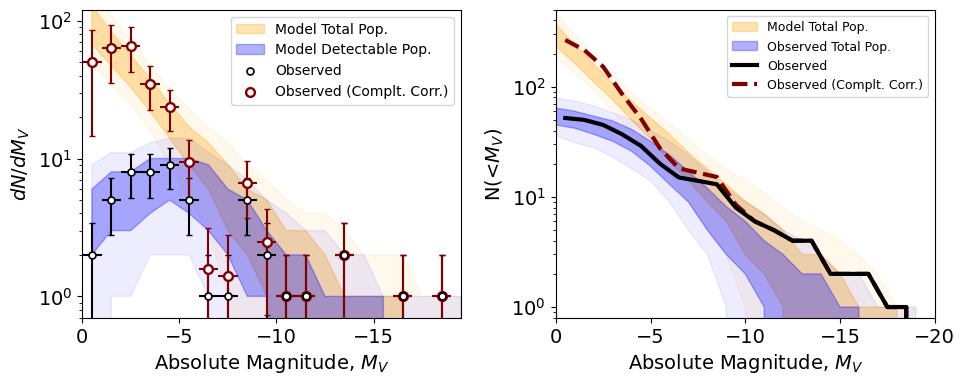

In [10]:
# Compute histogram
a, b = np.histogram(census_gal['M_V'], bins=np.linspace(-20, 0., 21))
ka, kb = np.histogram(data['M_V'], bins=np.linspace(-20, 0., 21))
x_mid = 0.5 * (b[1:] + b[:-1])

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# === Plot 1 ===
# Main axis
ax1 = axs[0]

# Fill bands
ax1.fill_between(x_mid, pp16_list, pp84_list, color='orange', alpha=0.3, label='Model Total Pop.', rasterized=True)
ax1.fill_between(x_mid, pp2_list, pp98_list, color='orange', alpha=0.07, rasterized=True)

ax1.fill_between(x_mid, p16_list, p84_list, color='blue', alpha=0.3, label='Model Detectable Pop.', rasterized=True)
ax1.fill_between(x_mid, p2_list, p98_list, color='blue', alpha=0.07, rasterized=True)

ax1.axvline(0.4)

# Observed data
ax1.scatter(x_mid, a, label='Observed', zorder=600, facecolors='white', s = 25,linewidth=1.2, edgecolors='k', rasterized=True)
ax1.errorbar(x_mid, a, yerr=np.sqrt(a), color='k', linestyle='none', capsize=2, rasterized=True)
ax1.errorbar(x_mid, a, xerr=0.5, color='k', linestyle='none', capsize=0, rasterized=True)

# Completeness corrected
ax1.scatter(x_mid, a * compt, label='Observed (Complt. Corr.)', zorder=500, s = 40,linewidth=1.7,
            facecolors='white', edgecolors='maroon', rasterized=True)
ax1.errorbar(x_mid, a * compt, yerr=np.sqrt(a) * compt, color='maroon',
             linestyle='none', capsize=2, rasterized=True)
ax1.errorbar(x_mid, a * compt, xerr=0.5, color='maroon',
             linestyle='none', capsize=0, rasterized=True)


# Axis settings for ax1
ax1.set_xlim(-0, -19.5)
ax1.set_ylim(0.7, 120)
ax1.set_xlabel('Absolute Magnitude, $M_V$', fontsize=14)
ax1.set_ylabel('$dN/dM_V$', fontsize=14)
ax1.set_yscale('log')
ax1.tick_params(axis='both', labelsize=14)
ax1.legend()



# === Plot 2 ===


x_vals = np.linspace(-20, 0., 21)
axs[1].fill_between(x_vals, ppp16_list, ppp84_list, color='orange', alpha=0.3, label='Model Total Pop.', rasterized=True)
axs[1].fill_between(x_vals, ppp2_list,  ppp98_list, color='orange', alpha=0.07, rasterized=True)

axs[1].fill_between(x_vals, pppp16_list, pppp84_list, color='blue', alpha=0.3, label='Observed Total Pop.', rasterized=True)
axs[1].fill_between(x_vals, pppp2_list,  pppp98_list, color='blue', alpha=0.07, rasterized=True)


cdf = np.cumsum(a )
axs[1].plot(x_mid, cdf, color='k',  linewidth=3.0, zorder=500, label='Observed', rasterized=True)

cdf = np.cumsum(a * compt)
axs[1].plot(x_mid, cdf, color='maroon', ls='dashed',  linewidth=3.0, label='Observed (Complt. Corr.)', rasterized=True)


#cdf = np.cumsum(ka )
#axs[1].plot(x_mid, cdf, color='indigo', ls='-.',  linewidth=3.0, label='All known galaxies', rasterized=True)


axs[1].set_xlim(0, -20)
axs[1].set_ylim(0.8, 500)
axs[1].set_yscale('log')
axs[1].set_xlabel('Absolute Magnitude, $M_V$', fontsize=14)
axs[1].set_ylabel('N(<$M_V$)', fontsize=14)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=9)




#plt.tight_layout()
fig.subplots_adjust(wspace=0.25)
#plt.savefig('figures/Fig9.pdf', bbox_inches='tight',)
plt.show()

We construct radial distribution plots analogous to those shown in Figure 10.

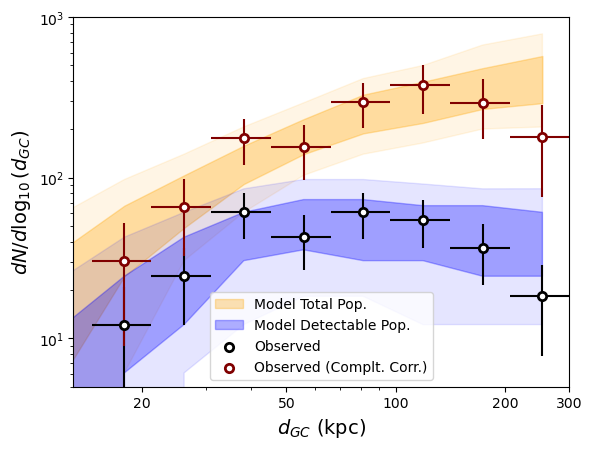

In [11]:
d_normalizer = np.median(np.log10(xd_values[1:]) - np.log10(xd_values[:-1]))

xd_middle =  0.5*(xd_values[:-1]+ xd_values[1:])
x_err = xd_middle - xd_values[:-1]
a, b = np.histogram(census_gal['distance_gc'], bins=xd_values)

plt.fill_between(xd_middle, dd16_list/d_normalizer, dd84_list/d_normalizer, color='orange', alpha=0.3, label='Model Total Pop.', rasterized=True)
plt.fill_between(xd_middle, dd2_list/d_normalizer,  dd98_list/d_normalizer, color='orange', alpha=0.1, rasterized=True)




plt.fill_between(xd_middle, d16_list/d_normalizer, d84_list/d_normalizer, color='blue', alpha=0.3, label='Model Detectable Pop.', rasterized=True)
plt.fill_between(xd_middle, d2_list/d_normalizer,  d98_list/d_normalizer, color='blue', alpha=0.1, rasterized=True)



plt.scatter(xd_middle , a/d_normalizer, label='Observed', zorder=500, facecolors='white', linewidth=2, edgecolors='k', rasterized=True)
plt.errorbar(xd_middle , a/d_normalizer, yerr=np.sqrt(a)/d_normalizer, xerr=x_err, color='k', linestyle='none', capsize=0, rasterized=True)


plt.scatter(xd_middle , a * d_compt/d_normalizer, label='Observed (Complt. Corr.)', zorder=500,
           facecolors='white', linewidth=2, edgecolors='maroon', rasterized=True)
plt.errorbar(xd_middle , a * d_compt/ d_normalizer, yerr=np.sqrt(a)/d_normalizer * d_compt, xerr=x_err, color='maroon', linestyle='none', capsize=0, rasterized=True)



plt.xlim(13,280)
plt.ylim(5,1000)
#plt.ylim(0.,80)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$d_{GC}$ (kpc)', fontsize =14)
plt.ylabel(r'$dN/d \log_{10}(d_{GC})$', fontsize =14)
plt.legend(loc='lower center')

custom_ticks = [20,50, 100,200,300]  # Replace with your desired tick positions
custom_labels = [str(tick) for tick in custom_ticks]  # Labels as strings

plt.xticks(custom_ticks, custom_labels)

#plt.savefig('figures/Fig10.pdf', bbox_inches='tight')

plt.show()

Finally, we made size-luminosity relation plots similar to Figure 11

Text(0, 0.5, '$r_{\\rm half}$ (pc)')

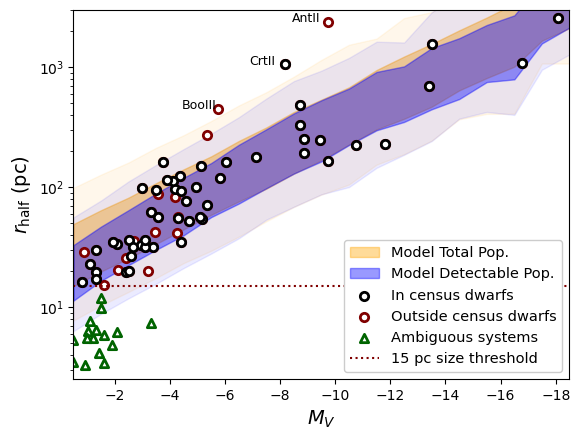

In [12]:
bist_list = ['AntII', 'CrtII', 'BooIII']
big_system = data[np.in1d(data['abbrev'], bist_list )]

size_array = np.arange(-19,0,1)
size_middle = size_array+ 0.5

plt.fill_between(size_middle, 10**np.array(s16_list), 10**np.array(s84_list), color='orange', alpha=0.4, label='Model Total Pop.')
plt.fill_between(size_middle, 10**np.array(s2_list),  10**np.array(s98_list), color='orange', alpha=0.08)

plt.fill_between(size_middle, 10**np.array(ss16_list), 10**np.array(ss84_list), color='blue', alpha=0.4, label='Model Detectable Pop.')
plt.fill_between(size_middle, 10**np.array(ss2_list),  10**np.array(ss98_list), color='blue', alpha=0.08)


for i in range(len(big_system['M_V'])):
    plt.text(
        np.array(big_system['M_V'])[i]+1.3, np.array(big_system['rhalf_sph_physical'])[i], 
        np.array(big_system['abbrev'])[i],
        fontsize=9
            )


plt.scatter(census_gal['M_V'], (census_gal['rhalf_sph_physical']), facecolors='white', linewidth=2, edgecolors='k', zorder=500,label='In census dwarfs')
plt.scatter(data['M_V'], (data['rhalf_sph_physical']), facecolors='white', linewidth=2, edgecolors='maroon', label='Outside census dwarfs')

plt.scatter(ambigous_data['M_V'], (ambigous_data['rhalf_sph_physical']), facecolors='white',marker="^", linewidth=2, edgecolors='darkgreen', label='Ambiguous systems')


plt.axhline(15, color='maroon' , ls=':', label='15 pc size threshold')


plt.xlim(-0.5,-18.5)
plt.yscale('log')
plt.ylim(2.5,3000)
plt.xlabel(r'$M_V$', fontsize =14)
plt.legend(fontsize=10.5,framealpha=1)
plt.ylabel(r'$r_{\rm half}$ (pc)', fontsize =14)
#plt.savefig('figures/Fig11.pdf', bbox_inches='tight')